In [10]:
import gymnasium as gym
import numpy as np
import time
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from numpy.typing import ArrayLike
from typing import Any, Union, Iterable

COLORS = mcolors.CSS4_COLORS

# GYMNASIUM FRAMEWORK : BlackJack

Let's explore a version of BlackJack where 
- there are two players only;
- the card dealer has a fixed policy.

An observation consists in a triple $(s, o, a) \in \{1\dots32\}\times \{1\dots11\} \times \{0, 1\}$ with :
- $s$ the value of our current hand 
- $o$ the value of our opponent's hand
- $a$ is $1$ if our player has a usable ace (can take value $1$ or $11$), $0$ otherwise 

The action space is $\{0 = stick, 1 = hit\}$.

The rewards are in $\{-1, 0, +1\}$.

## Basics of Gym.

In [3]:
# First make a new environment choising the desired game and a render_mode ('human' means there will be a pygame window displaying the game states, 'rgb_array' removes display)
env = gym.make('Blackjack-v1', render_mode = 'rgb_array')

# Before starting any episode, reset the env to create a new initial step
observation, info = env.reset()

## Fixed policies are inefficient!

In [3]:
# Create five probability distributions over {0, 1}:
# - 2 deterministic
# - 3 stochastic
probability_distributions = list(map(lambda tuple: np.array(tuple, dtype = np.float64), zip(np.arange(0, 1.01, step = .25), np.arange(1, -0.01, step = -.25))))


N_DISTRIBUTIONS = len(probability_distributions)
N_EPISODES = 10000
N_RUNS = 100

total_reward = np.zeros(shape = (N_DISTRIBUTIONS, N_RUNS, N_EPISODES), dtype = np.float64)

for index_distribution, distribution in tqdm(enumerate(probability_distributions)):
    for run in range(N_RUNS):
        for episode in range(N_EPISODES):
            
            observation, info = env.reset()
            current_sum, opponent_sum, available_ace = observation


            episode_over = False
            
            while not episode_over:
                action = env.action_space.sample(probability = distribution)

                observation, reward, terminated, truncated, info = env.step(action)
                
                current_sum, opponent_sum, available_ace = observation

                total_reward[index_distribution, run, episode] += reward
                episode_over = terminated

            episode += 1

env.close()

5it [04:04, 48.93s/it]


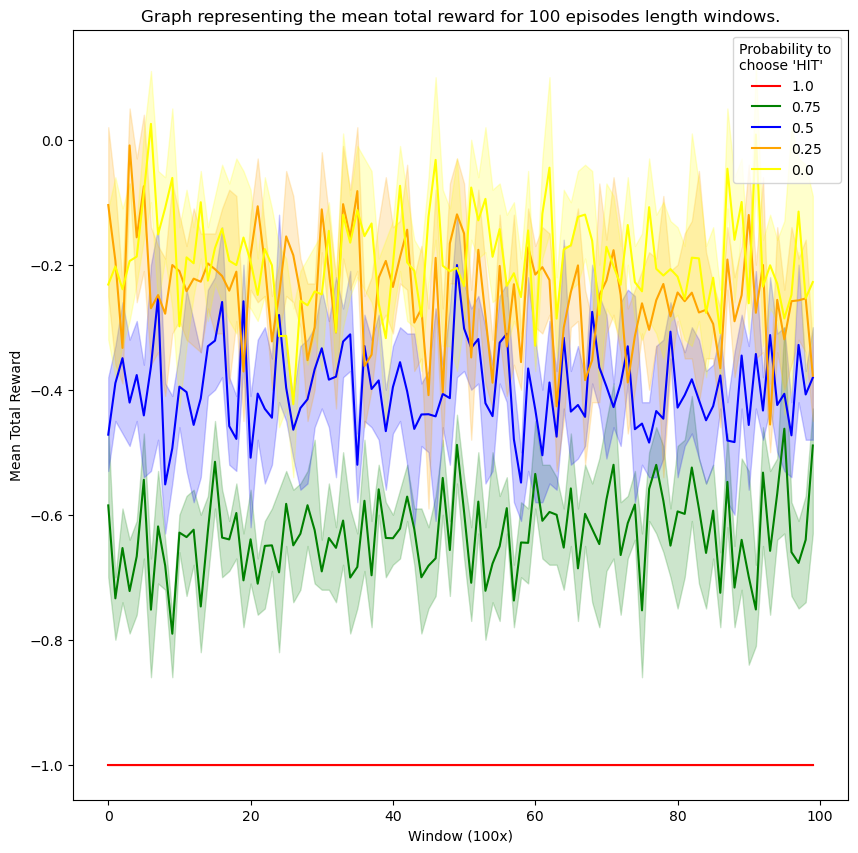

In [5]:
# Display the mean over the last 100 episodes
fig, ax = plt.subplots(1, 1, figsize = (10, 10))

support = np.arange(0, N_EPISODES // 100)

colors = ["red", "green", "blue", "orange", "yellow"]
for index_distribution, distribution in enumerate(probability_distributions):
    current_color = colors[index_distribution]

    image = np.array([total_reward[index_distribution, :,i:i+100].mean(axis = 1) for i in support])

    y_min = image.min(axis = 0)
    y_max = image.max(axis = 0)

    ax.set_xlabel("Window (100x)")
    ax.set_ylabel("Mean Total Reward")
    ax.set_title("Graph representing the mean total reward for 100 episodes length windows.")

    ax.fill_between(support, y_min, y_max, alpha = .2, color = current_color)
    ax.plot(support, image.mean(axis = 0), label = f"${distribution[1]}$", color = current_color)

ax.legend(title = "Probability to \nchoose 'HIT'")

<u>Test conditions</u>:
- 100 runs of 10000 episodes.
- study of the mean total reward on 100 episode-long windows.

<u>Main takeways</u>: 
- Fixed policies are far from being efficient in the blakcjack context.
- It seems to be less risky to play 'STICK' than 'HIT'.

### NEXT STEP : HEURISTICAL APPROACH / CONTEXT-AWARE FIXED POLICIES

Here we will analyze the state space of the blackjack game. Remember our observations live in $\{1\dots32\}\times \{1\dots11\} \times \{0,1\} $.

#### Heuristic construction - Only with $s$

Let's build some rules for our player : 
1. if $s \le 11$, he should 'HIT', for any values of $o$.
2. if $s = 21$, he should 'STICK, for any values of $o$.
3. if $s \in \{12\dots20\}$, the choice is not fast-forward. Compute the probability that the player bust : 
    $1 - \frac{4 \cdot (21 - s)}{52} $. This works because the valid cards are not faces i.e $21-s \in \{1...9\}$.

The policy can be sum up as follows : 

$\mathbb{P}(1) = \begin{cases}
    1, \text{if } s \le 11 \\
    0, \text{if } s = 21 \\
    \frac{4 \cdot (21 - s)}{52}, \text{otherwise}\end{cases}$
    
$\mathbb{P}(0) = \begin{cases}
    0, \text{if } s \le 11 \\
    1, \text{if } s = 21 \\
    1 - \frac{4 \cdot (21 - s)}{52}, \text{otherwise}\end{cases}$

In [4]:
def policy(observation: tuple[int, int, int], action_space: gym.spaces.Discrete) -> int:
    s, o, a = observation

    if s <= 11:
        return 1

    elif s == 21:
        return 0
    
    else:
        p_hit = 4 * (21 - s) / 52
        distribution = np.array([p_hit, 1 - p_hit], dtype = np.float64)
        return action_space.sample(probability = distribution)

In [7]:
N_EPISODES = 10000
N_RUNS = 100

total_reward = np.zeros(shape = (N_RUNS, N_EPISODES), dtype = np.float64)

for run in range(N_RUNS):
    for episode in range(N_EPISODES):
        
        observation, info = env.reset()
        current_sum, opponent_sum, available_ace = observation


        episode_over = False
        
        while not episode_over:
            action = policy(observation = observation, action_space = env.action_space)

            observation, reward, terminated, truncated, info = env.step(action)
            
            current_sum, opponent_sum, available_ace = observation

            total_reward[run, episode] += reward
            episode_over = terminated

        episode += 1

env.close()

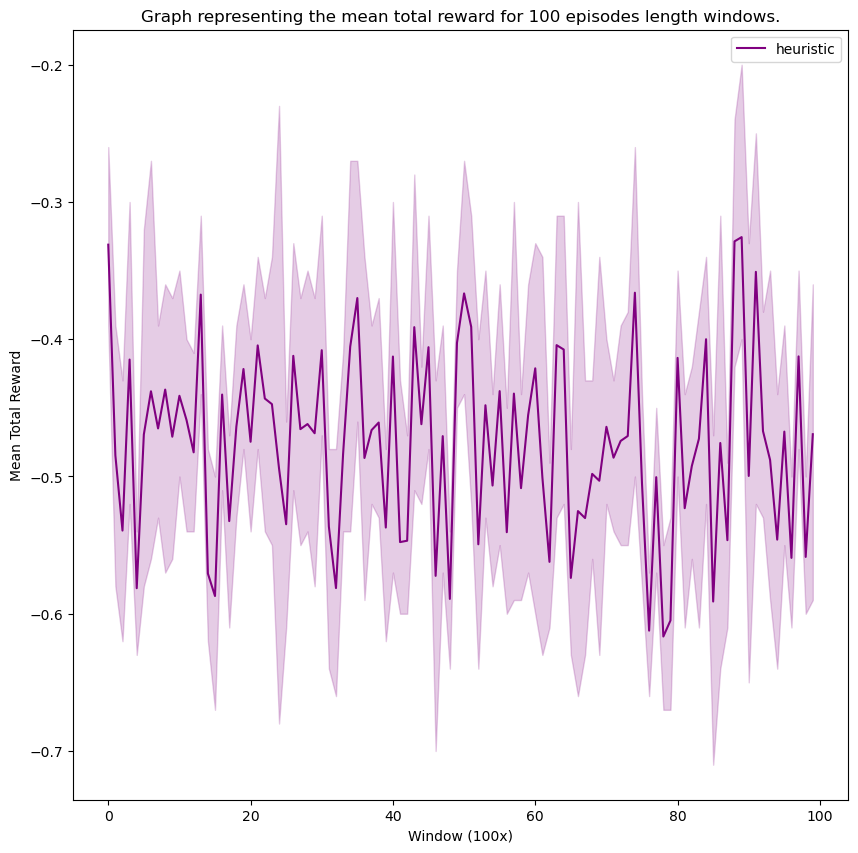

In [8]:
# Display the mean over the last 100 episodes
fig, ax = plt.subplots(1, 1, figsize = (10, 10))

support = np.arange(0, N_EPISODES // 100)

color = "purple"

image = np.array([total_reward[:,i:i+100].mean(axis = 1) for i in support])

y_min = image.min(axis = 0)
y_max = image.max(axis = 0)

ax.set_xlabel("Window (100x)")
ax.set_ylabel("Mean Total Reward")
ax.set_title("Graph representing the mean total reward for 100 episodes length windows.")

ax.fill_between(support, y_min, y_max, alpha = .2, color = color)
ax.plot(support, image.mean(axis = 0), label = f"heuristic", color = color)

ax.legend()

<u>Test conditions</u>:
- 100 runs of 10000 episodes.
- study of the mean total reward on 100 episode-long windows.

<u>Main takeways</u>: 
- This policy is still bad as it only takes advantage of the player's current sum and not of the opponent one.
- A lot of variance in the rewards (big spikes).

## Monte Carlo methods for episodic MDP

Here we will study methods that do not need the knowledge of reward and transition models : Monte Carlo methods. We approximate $v(s)$ by $G_i = \sum_{i=1}^{n} \gamma^i r_i$. There exists two variants for each algorithm :
- <b>First-visit Monte Carlo</b> / when simulating an episode : $s_0 \to_{a_1} (s_1, r_1) \to_{a_2} (s_2, r_2) \to_{a_3} (s_1, r_3) \to_{a_4} (s_4, r_4)$, we update $v(s_1)$ with $G_1$.
- <b>Each-visit Monte Carlo</b> / when simulating an episode : $s_0 \to_{a_1} (s_1, r_1) \to_{a_2} (s_2, r_2) \to_{a_3} (s_1, r_3) \to_{a_4} (s_4, r_4)$, we update $v(s_1)$ with $G_1$ and $G_3$.

The algorithms that are being implemented are :
- <b>On-policy Monte Carlo</b> / estimate and improve a (soft-)policy while using it during random exploration. Tradeoff between exploration and exploitation.
- <b>Off-policy Monte Carlo</b> / two policies are being used : current behavior and optimized policies. A greedy policy is used to improve the estimated one.

In [165]:
class Policy:
    """Class that represents a policy, i.e. a distribution over a state and an action space.
    
    Consider that the distribution is stored as follows : pi(a|s) => pi has shape (#{states} x #{actions})
    """

    def __init__(self, observation_space: gym.spaces.Space, action_space: gym.spaces.Space, policy: ArrayLike = []):
        assert isinstance(observation_space, gym.spaces.Space)  and isinstance(action_space, gym.spaces.Space), "Both spaces must be gym.spaces.Space typed."
        
        self.observation_space = observation_space
        self.action_space = action_space

        # Retrieve dims / flatdim if the shape yield a None object
        self.observation_shape = observation_space.shape if observation_space.shape != () else (gym.spaces.flatdim(observation_space),)
        self.action_shape = action_space.shape if action_space.shape != () else (gym.spaces.flatdim(action_space),)

        print(self.observation_shape, self.action_shape)

        if not policy:
            self.policy = np.zeros(shape = (*self.observation_shape, *self.action_shape), dtype = np.float64)

        else:
            policy = np.array(policy, dtype = np.float64)
            if policy.shape == (*self.observation_shape, *self.action_shape):
                self.policy = policy

            elif policy.shape == (*self.action_shape, *self.observation_shape):
                self.policy = policy.T

            else:
                raise ValueError("The policy argument has not matching shape with spaces.")
            
    def get_random_fixed_policy(self) -> None:
        """Function that generates a random fixed policy uniformly."""
        for observation in range(self.observation_space.n):
            self.policy[observation, self.action_space.sample()] = 1.

    def get_random_policy(self) -> None:
        """Function that generates a random policy."""
        for observation in range(self.observation_space.n):
            random_seq = np.random.rand(self.action_space.n)
            self.policy[observation, :] = random_seq / random_seq.sum()
    
    def pi(self, observation: Any, action: Any = None) -> Union[np.float64, Iterable[np.float64]]:
        assert observation not in self.observation_space, "The observation is not part of the observation space."
        assert action is not None and action not in self.action_space, "The action is not part of the observation space."
        
        if action is None:
            return self.pi[observation,:]
        
        return self.pi[observation, action]
        
    def __str__(self):
        return f"{self.observation_space=},\n{self.action_space=},\n{self.policy=}"



In [166]:
ospace = gym.spaces.discrete.Discrete(3)
aspace = gym.spaces.discrete.Discrete(2)

In [167]:
p = Policy(observation_space=ospace, action_space=aspace)

(3,) (2,)


In [170]:
print(p.policy)

[[0.07193637 0.92806363]
 [0.07180576 0.92819424]
 [0.61897521 0.38102479]]


In [168]:
p.get_random_policy()